In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

In [2]:
PROCESSED_DIR = "data/processed"

### 1. Load Data
---

In [3]:
# Treatments processed
treatments_df = pd.read_csv(os.path.join(PROCESSED_DIR, "treatments_processed.tsv"), sep='\t', index_col=0)


In [4]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_with_ccp_03.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

# Not imputed
X = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_for_ccp_02.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Imputed
# Xi_median = pd.read_csv("data/imputed/median_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
# Xi_knn = pd.read_csv("data/imputed/knn_qvars_01.tsv", sep="\t", index_col=0).rename(columns=amyloid.ddict_unclean)
# Xi_mice = pd.read_csv("data/imputed/mice_qvars_05.tsv", sep="\t").rename(columns={'X24_hr_UTP':'24_hr_UTP'}).rename(columns=amyloid.ddict_unclean)

In [5]:
symptom_onsets = ['Cardiopulmonary symptom onset', 'Renal signs/symptom onset', 'Neurologic symptom onset']

for symptom_onset in symptom_onsets:
    print(symptom_onset, data_df[data_df[symptom_onset] > data_df["Date of admission to center"]].shape[0])

Cardiopulmonary symptom onset 26
Renal signs/symptom onset 23
Neurologic symptom onset 15


#### ESKD Treatment & Timing
---

In [70]:
# Load RRT dates
rrt_files = ["PeritonealDialysis.csv","Hemodialysis.csv","KidneyTransplant.csv","AddnlPD.csv"]

rrt_df = list()

# Add all modalities
for rrt in rrt_files:
    _df = pd.read_csv(os.path.join("data/raw",rrt),sep=",",index_col=0)
    _df["modality"] = "Peritoneal Dialysis" if rrt in ["PeritonealDialysis.csv","AddnlPD.csv"] else rrt.split(".csv")[0]
    rrt_df.append(_df)

rrt_df = pd.concat(rrt_df)

# Fix dates mis-entered in database
rrt_df.loc[9423, "Date performed"] = "7/27/1994"
rrt_df.loc[9665, "Date performed"] = "4/5/2003"

# Save file
rrt_df.to_csv("data/processed/rrt_dates_all.tsv", sep="\t")

# Filter for duplicate entries (ie patient has multiple RRT options, we only want first one)
rrt_filt_df = rrt_df.dropna(subset=["Date performed"]).sort_values("Date performed").reset_index().drop_duplicates(subset="Code ID").set_index("Code ID")
rrt_filt_df = pd.concat([rrt_filt_df,rrt_df.loc[np.setdiff1d(rrt_df.index,rrt_filt_df.index),:]])

In [71]:
# Create ESKD dataframe
eskd_df = data_df.join(treatments_df[treatments_df["treatment_eskd"]].reset_index()[["Code ID","treatment_eskd"]].drop_duplicates(
    subset="Code ID").set_index("Code ID"))[["treatment_eskd"]]

eskd_df["treatment_eskd"] = eskd_df["treatment_eskd"].apply(lambda x: 1 if x==True else 0)

# Join ESKD dataframe to RRT timing
eskd_df = eskd_df.join(rrt_filt_df)
eskd_df = eskd_df.drop(columns=["Date of diagnosis"]).rename(columns={"Date performed":"Date of RRT Start","End date":"Date of RRT End","modality":"RRT Type"})
eskd_df = data_df[["Date of admission to center","Date of diagnosis","Date of death","Date of last visit","time","status","time_from_admission"]].join(eskd_df)
eskd_df["Date of RRT Start"] = pd.to_datetime(eskd_df["Date of RRT Start"], format="mixed")
eskd_df["Date of RRT End"] = pd.to_datetime(eskd_df["Date of RRT End"], format="mixed")

# Get time to ESKD
eskd_df['time_to_eskd'] = eskd_df.apply(lambda row: utils.get_time_eskd(row),1)
eskd_df['time_to_eskd_from_admission'] = eskd_df.apply(lambda row: utils.get_time_eskd(row, start_time="Date of admission to center"),1)

In [72]:
eskd_df[(eskd_df['time_to_eskd_from_admission']<0) & (eskd_df['treatment_eskd']==0)]

,Date of admission to center,Date of diagnosis,Date of death,Date of last visit,time,status,time_from_admission,treatment_eskd,Date of RRT Start,Date of RRT End,Comment,RRT Type,time_to_eskd,time_to_eskd_from_admission
Code ID,,,,,,,,,,,,,,
2013168,2013-10-09,2013-07-24,NaT,2013-10-08,0.208077,0,-0.002738,0,NaT,NaT,NaN,NaN,0.208077,-0.002738
2014033,2014-02-25,2012-09-01,NaT,2014-02-24,1.481177,0,-0.002738,0,NaT,NaT,NaN,NaN,1.481177,-0.002738
2017108,2017-06-30,2017-01-13,NaT,2017-06-26,0.449008,0,-0.010951,0,NaT,NaT,NaN,NaN,0.449008,-0.010951


In [75]:
# Competing risk
eskd_df['CR_event'] = eskd_df.apply(utils.get_cr_event,axis=1)
eskd_df['CR_time'] = eskd_df.apply(utils.get_cr_time,axis=1)

In [76]:
eskd_df.to_csv("data/processed/treatment_eskd.tsv", sep="\t")

#### Hematologic Response
---

In [136]:
def assign_tx_response(x):
    if x==0:
        return "n/a"
    elif x==1:
        return "No"
    elif x==2:
        return "Yes"
    elif x==3:
        return "Relapse"
    elif x==4:
        return "n/a"
    else:
        return "n/a"

In [139]:
hr_df = pd.read_csv("data/raw/HemeCR.csv", sep=",")
hr_df["response"] = hr_df['Complete response to treatment?'].apply(lambda x: assign_tx_response(x))
hr_df


,Code ID,Date of diagnosis,Complete response to treatment?,Visit date,"If relapse, date.",response
0,6102,11/8/96,NaN,12/16/96,NaN,n/a
1,6102,11/8/96,NaN,6/9/97,NaN,n/a
2,6102,11/8/96,NaN,4/13/09,NaN,n/a
3,6102,11/8/96,1.0,2/4/08,NaN,No
4,6102,11/8/96,2.0,6/22/98,NaN,Yes
...,...,...,...,...,...,...
8474,200051,1/7/00,NaN,5/1/00,NaN,n/a
8475,200051,1/7/00,NaN,9/11/00,NaN,n/a
8476,2000154,10/3/00,0.0,12/11/00,NaN,n/a
8477,2021163,9/17/21,1.0,11/8/21,NaN,No


### Explore
---

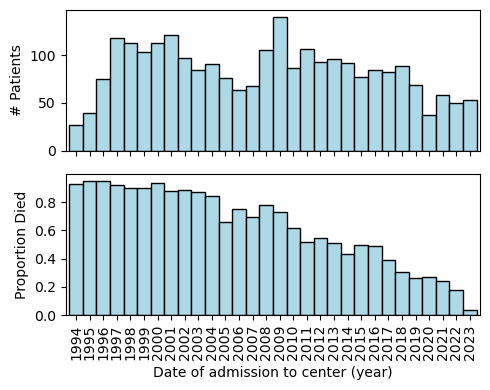

In [ ]:
data_df["Date of admission to center (year)"] = data_df["Date of admission to center"].dt.year
_df = pd.DataFrame(data_df.groupby("Date of admission to center (year)").size()).join(
    pd.DataFrame(data_df.groupby("Date of admission to center (year)")["status"].sum())).rename(columns={0:"patients"})
_df["proportion_died"] = _df["status"] / _df["patients"]

fig,axes = plt.subplots(2, 1, figsize=(5,4), sharex=True)

_df["patients"].plot(kind="bar", ax=axes[0], width=1, edgecolor='k', color='lightblue')
_df["proportion_died"].plot(kind="bar", ax=axes[1], width=1, edgecolor='k', color='lightblue')

axes[0].set_ylabel("# Patients")
axes[1].set_ylabel("Proportion Died")

plt.tight_layout()
plt.savefig("figures/proprotion_died_by_admission_yr.pdf", dpi=200, bbox_inches="tight")

In [11]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).join(data_df['cluster']).drop(columns=to_drop).dropna()
).join(data_df[["time","status"]])

Using 29 quantitative variables.
Using 35 categorical variables.
Total samples x feaures (one-hot encoded): (1601 x 76)


In [13]:
treatments_s = treatments_df.dropna(subset=["Start date"]).sort_values("Start date").reset_index().groupby("Code ID")["treatment_group"].agg(list)
treatments_s.name = "tx_by_date"

first_treatment_s = treatments_df.dropna(subset=["Start date"]).sort_values("Start date").reset_index().drop_duplicates(subset="Code ID", keep="first").set_index("Code ID")["treatment_group"]
first_treatment_s.name = "first_tx"

all_treatments_s = treatments_df.sort_values("Start date").reset_index().groupby("Code ID")["treatment_group"].agg(list)
all_treatments_s.name = "all_tx"

num_treatments_s = treatments_df.sort_values("Start date").reset_index().groupby("Code ID").size()
num_treatments_s.name = "num_tx"

comb_df = data_df.join(treatments_s).join(first_treatment_s).join(all_treatments_s).join(num_treatments_s)
comb_df = comb_df.dropna(subset=["cluster"])


In [14]:
comb_df.rename(columns=amyloid.ddict_clean).to_csv("data/processed/AL_with_ccp_tx_04.tsv", sep="\t")

In [16]:
comb_df.groupby("first_tx").size()

first_tx
BDR                                4
Bendamustine                       1
Cyclophosphamide                   5
Dara-CyBorD                       50
Daratumumab-based                 15
Glucocorticoid monotherapy        62
HDM/SCT                          420
IMiD-based                        82
Melphalan-based regimen          373
Other                              8
Other rituximab-based regimen      4
Proteasome inhibitor-based       424
RVD                               16
Supportive                         1
Venetoclax-based                   1
dtype: int64

In [94]:
comb_df.groupby(["cluster","first_tx"]).size().reset_index().pivot(values=0, columns="cluster", index="first_tx").fillna(0).astype(int)

cluster,1,2,3
first_tx,,,
BDR,3,0,1
Bendamustine,0,0,1
Cyclophosphamide,2,3,0
Dara-CyBorD,17,17,16
Daratumumab-based,6,4,5
Glucocorticoid monotherapy,24,27,11
HDM/SCT,144,212,64
IMiD-based,38,23,21
Melphalan-based regimen,115,161,97
